### 前言
#### [数据集源自kaggle](https://www.kaggle.com/c/dsg-hackathon/data)，空气质量预测数据集，描述了多个站点的天气状况，并要求对随后三天的空气质量测量进行预测。具体而言，为多个站点提供温度、压力、风速和风向等天气观测值，持续八天。目标是预测未来三天在多个地点的空气质量测量结果。预测提前期不是连续的;相反，必须在 72 小时预测期内预测特定的提前期;它们是：+1, +2, +3, +4, +5, +10, +17, +24, +48, +72
### Part 1 可视化和探索空气污染数据
#### 统计数据中的NaN值

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
df=pd.read_csv('TrainingData.csv')
print(df.shape)
values=df.values
data=values[:,6:].astype('float32')
# 统计缺失值的数量
total_missing=np.count_nonzero(np.isnan(data))
percent_missing=total_missing/data.size*100
print('Total Missing: %d/%d (%.1f%%)'%(total_missing,data.size,percent_missing))

(37821, 95)
Total Missing: 1922092/3366069 (57.1%)


##### 可以看到，缺少多于 40% 的数据，数据非常不完整。

#### 将数据按照标签分块

Total Chunks: 208


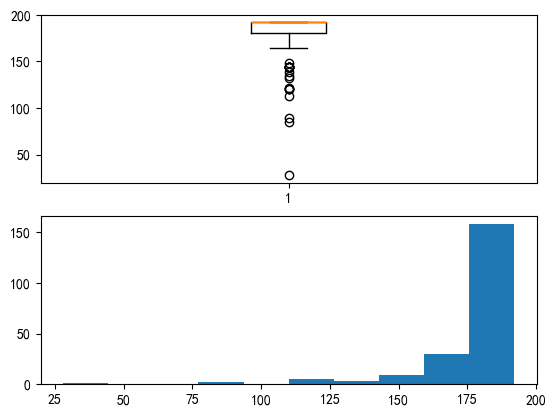

In [3]:
# 按“chunkID”变量（列索引 1）对数据进行分组。如果每个区块是八天，观测值是每小时一次，那么我们预计每个区块有 （8 * 24） 或 192 行数据。
# 如果有 37，821 行数据，则必须存在大于或少于 192 小时的块，因为 37，821/192 大约是 196.9 个块。
def to_chunks(values,chunk_ix=1):
    chunks=dict()
    chunk_ids=np.unique(values[:,chunk_ix])
    # 按chunk id 分组
    for chunk_id in chunk_ids:
        selection=values[:,chunk_ix]==chunk_id
        chunks[chunk_id]=values[selection,:]
    return chunks
def plot_chunk_durations(chunks):
    chunk_durations=[len(v) for k,v in chunks.items()]
    plt.subplot(2,1,1)
    plt.boxplot(chunk_durations)
    plt.subplot(2,1,2)
    plt.hist(chunk_durations)
    plt.show()
df_2=pd.read_csv('TrainingData.csv')
values=df_2.values
chunks=to_chunks(values)
print('Total Chunks: %d' % len(chunks))
plot_chunk_durations(chunks)

##### 可以看到有 208 个区块数，这表明每小时观测的数量确实必须在各个区块之间变化。中位数确实是192，这意味着大多数区块都有八天的观测时间或接近它。持续时间的长尾，大约 25 行。
#### 块连续性

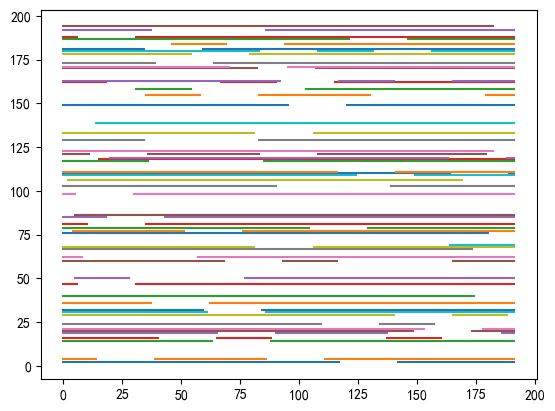

In [4]:
def plot_discontiguous_chunks(chunks,row_in_chunk_ix=2):
    n_steps=8*24
    for c_id,rows in chunks.items():
        if rows.shape[0]==n_steps:
            continue
        series=[np.nan for _ in range(n_steps)]
        for row in rows:
            r_id=row[row_in_chunk_ix]-1
            series[r_id]=c_id
        plt.plot(series)
    plt.show()
plot_discontiguous_chunks(chunks)

##### 图形中，其中每个缺少数据的区块都有一行。每个块的行中分隔符的数量和长度可以了解每个块中的观察结果恰好有多不连续。许多块确实具有很长的连续数据，这对于建模来说是一个好兆头。此外，并非所有这些块在块的末尾都有观察结果：需要预测之前的时间段。对于那些寻求持续最近观察的模型来说，这些将是一个挑战。

#### 区块内的每日覆盖率

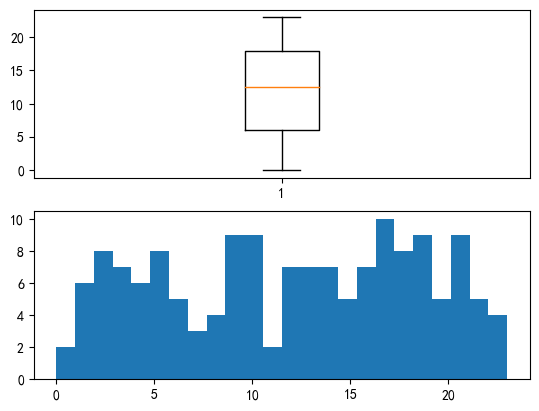

In [5]:
def plot_chunk_start_hour(chunks,hour_in_chunk_ix=5):
    chunk_start_hours=[v[0,hour_in_chunk_ix] for k,v in chunks.items() if len(v)==192]
    plt.subplot(2,1,1)
    plt.boxplot(chunk_start_hours)
    plt.subplot(2,1,2)
    plt.hist(chunk_start_hours,bins=24)
    plt.show()
plot_chunk_start_hour(chunks)

##### 可以看到一天中 24 小时内开始时间的合理均匀分布。此外，这意味着每个区块的预测间隔也将在 24 小时内发生变化。这为可能预期标准三天预测期（午夜到午夜）的模型增加了皱纹

#### 每个块的时间结构

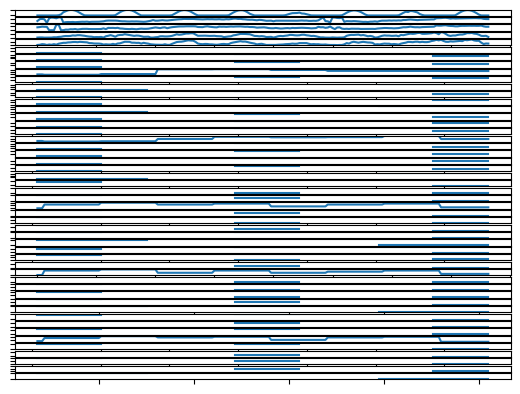

In [6]:
def plot_chunk_inputs(chunks,c_ids):
    plt.figure()
    inputs=range(6,56)
    for i in range(len(inputs)):
        ax=plt.subplot(len(inputs),1,i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        column=inputs[i]
        for chunk_id in c_ids:
            rows=chunks[chunk_id]
            plt.plot(rows[:,column])
    plt.show()
plot_chunk_inputs(chunks,[1]) # 1个区块的所有输入变量的并行时间序列线图

##### 可以看到，前五个变量的观测值看起来相当完整;这些是太阳辐射、风速和风向。其余的变量看起来很不完整，至少对于这个块来说是这样。

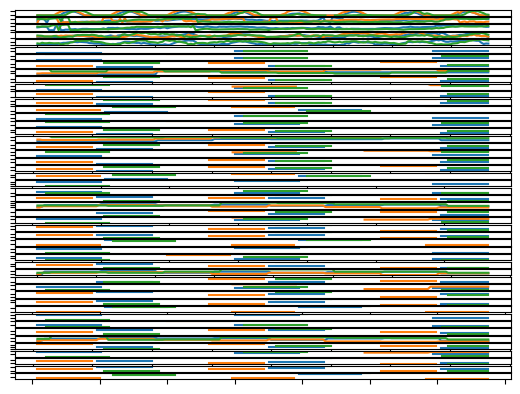

In [7]:
plot_chunk_inputs(chunks,[1,3,5]) # 3个区块的所有输入变量的并行时间序列线图

##### 可以看到，这三个数字确实在每个线图中显示了相似的结构。这是一个有用的发现，因为它表明跨多个块对相同的变量进行建模可能很有用。

#### 输入数据分布

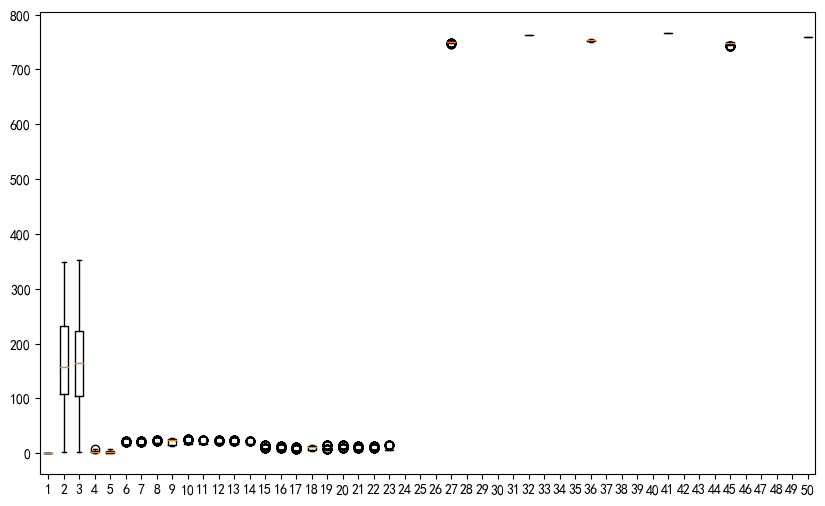

In [8]:
def plot_chunk_input_boxplots(chunks,c_id):
    rows=chunks[c_id]
    plt.figure(figsize=(10,6))
    plt.boxplot(rows[:,6:56])
    plt.show()

plot_chunk_input_boxplots(chunks,1)

##### 可以看到，相同类型的变量可能具有相同的观测分布，并且每组变量似乎都有不同的单位。也许是风向的度，压力的百分之一，温度的摄氏度等等。

#### 目标块的时间结构

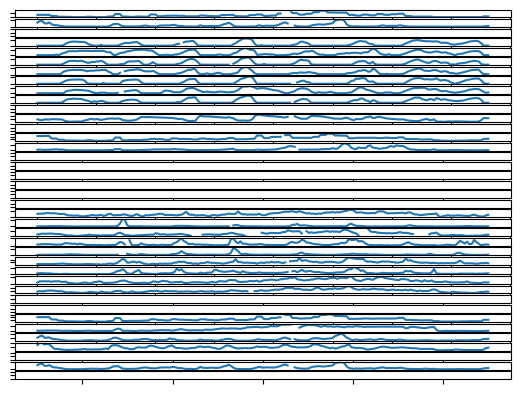

In [9]:
# 1 个区块的所有目标变量的并行时间序列线图
def plot_chunk_targets(chunks, c_ids):
    plt.figure()
    targets = range(56, 95)
    for i in range(len(targets)):
        ax = plt.subplot(len(targets), 1, i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        column = targets[i]
        for chunk_id in c_ids:
            rows = chunks[chunk_id]
            plt.plot(rows[:,column])
    plt.show()
plot_chunk_targets(chunks,[1])

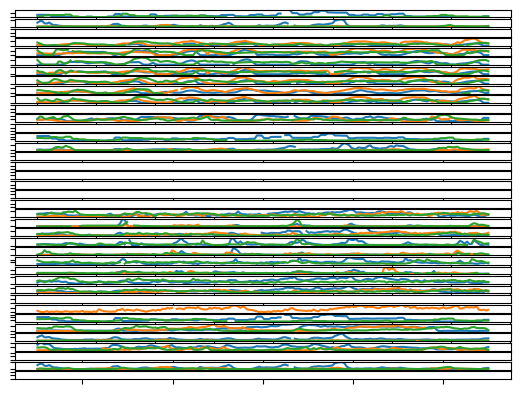

In [10]:
# 3 个区块的所有目标变量的并行时间序列线图
plot_chunk_targets(chunks, [1, 3 ,5])

##### 许多图都有循环结构。大多数有八个峰值，很可能对应于块内八天的观测。可以直接对这种季节性结构进行建模，也可以在建模时从数据中删除，并添加回预测的区间。
#### 目标变量的箱线图

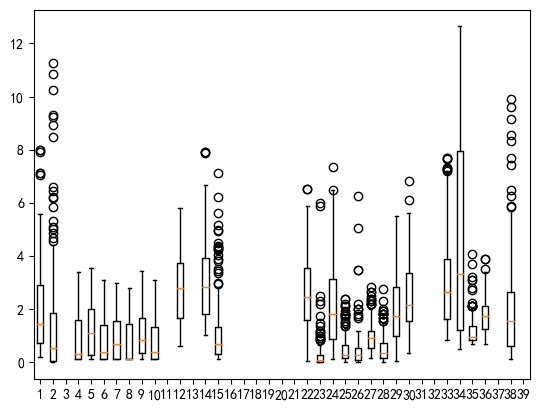

In [11]:
# 一个块的目标变量的箱线图
def plot_chunk_targets_boxplots(chunks, c_id):
    rows = chunks[c_id]
    plt.boxplot(rows[:,56:])
    plt.show()
plot_chunk_targets_boxplots(chunks, 1)

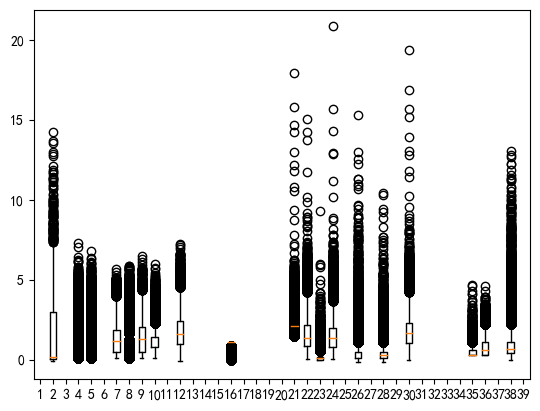

In [12]:
# 所以数据的目标变量的箱线图
def plot_target_boxplots(values):
    plt.boxplot(values[:,56:])
    plt.show()
plot_target_boxplots(values)

##### 可以看到，许多变量的中位数接近零或 1;我们还可以看到大多数变量的不对称分布很大，这表明变量可能与异常值存在偏差。
#### 目标块通过柱状图看空值比例

11 91.48885539779488
20 91.48885539779488
29 91.48885539779488
38 91.48885539779488
47 91.48885539779488
58 95.38880516115385
66 96.9805134713519
68 95.38880516115385
72 97.31630575606145
86 95.38880516115385
92 95.38880516115385
94 95.38880516115385


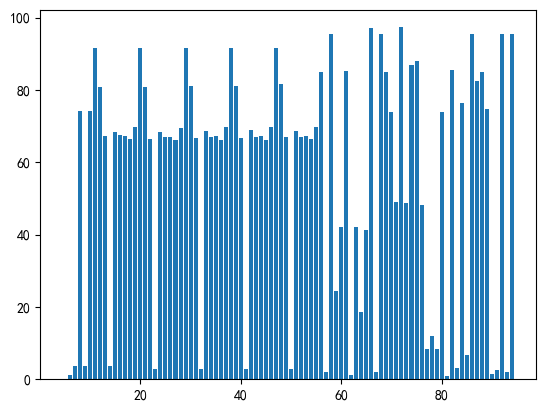

In [13]:
# bar chart of the ratio of missing data per column
def plot_col_percentage_missing(values, ix_start=5):
    ratios = list()
    for col in range(ix_start, values.shape[1]):
        col_data = values[:, col].astype('float32')
        ratio = np.count_nonzero(np.isnan(col_data)) / len(col_data) * 100
        ratios.append(ratio)
        if ratio > 90.0:
            print(col, ratio)
    col_id = [x for x in range(ix_start, values.shape[1])]
    plt.bar(col_id, ratios)
    plt.show()
plot_col_percentage_missing(values) # 每列缺失数据百分比的条形图

##### 可以看到，缺失数据的比率可能存在一些分层，聚类低于 10%，聚类在 70% 左右，聚类高于 90%。我们还可以看到输入变量和目标变量之间的分离，其中前者非常规则，因为它们显示了在不同站点上测量的相同变量类型。一些目标变量的如此少量的数据表明，除了过去的观测值之外，还需要利用其他因素来进行预测。
#### 目标变量的直方图分布

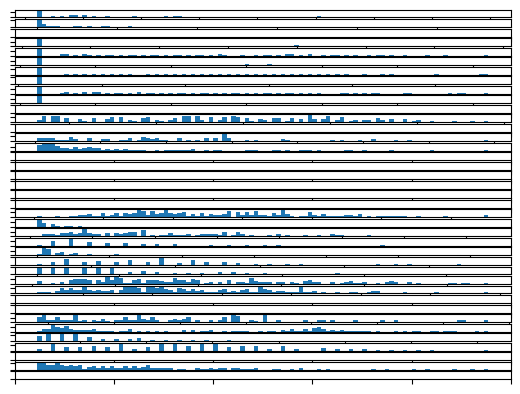

In [14]:
# 一个块的每个目标变量的直方图
def plot_chunk_targets_hist(chunks, c_ids):
    plt.figure()
    targets = range(56, 95)
    for i in range(len(targets)):
        ax = plt.subplot(len(targets), 1, i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        column = targets[i]
        for chunk_id in c_ids:
            rows = chunks[chunk_id]
            col = rows[:,column].astype('float32')
            if np.count_nonzero(np.isnan(col)) < len(rows):
                plt.hist(col[~np.isnan(col)], bins=100)
    plt.show()
plot_chunk_targets_hist(chunks, [1])

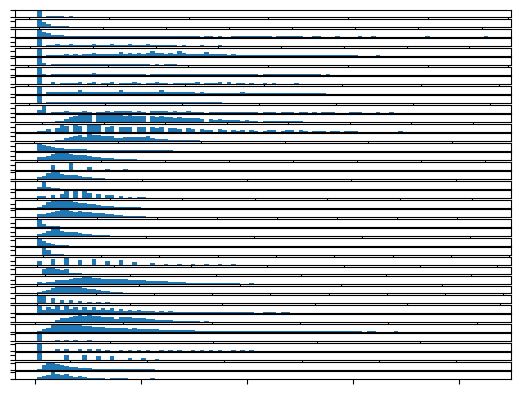

In [15]:
# 整个训练数据集的每个目标变量的直方图
def plot_target_hist(values):
    plt.figure()
    targets = range(56, 95)
    for i in range(len(targets)):
        ax = plt.subplot(len(targets), 1, i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        column = targets[i]
        col = values[:,column].astype('float32')
        if np.count_nonzero(np.isnan(col)) < len(values):
            plt.hist(col[~np.isnan(col)], bins=100)
    plt.show()
plot_target_hist(values)

##### 前几个图可能显示出高度偏斜的分布，其核心可能是也可能不是高斯。可以看到许多带有间隙的高斯分布，这表明对高斯分布的连续变量施加了离散测量。还可以看到一些显示指数分布的变量。

### Part 2 空气污染预测的BaseLine模型
#### 将数据拆分成训练集和测试集

In [16]:
def to_chunks(values, chunk_ix=1):
    chunks = dict()
    chunk_ids = np.unique(values[:, chunk_ix])
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks[chunk_id] = values[selection, :]
    return chunks

def split_train_test(chunks, row_in_chunk_ix=2):
    train, test = list(), list()
    cut_point = 5 * 24
    for k,rows in chunks.items():
        train_rows = rows[rows[:,row_in_chunk_ix] <= cut_point, :]
        test_rows = rows[rows[:,row_in_chunk_ix] > cut_point, :]
        if len(train_rows) == 0 or len(test_rows) == 0:
            print('>dropping chunk=%d: train=%s, test=%s' % (k, train_rows.shape, test_rows.shape))
            continue
        indices = [1,2,5] + [x for x in range(56,train_rows.shape[1])]
        train.append(train_rows[:, indices])
        test.append(test_rows[:, indices])
    return train, test

def get_lead_times():
    return [1, 2 ,3, 4, 5, 10, 17, 24, 48, 72]

def to_forecasts(test_chunks, row_in_chunk_ix=1):
    lead_times = get_lead_times()
    cut_point = 5 * 24
    forecasts = list()
    for rows in test_chunks:
        chunk_id = rows[0, 0]
        for tau in lead_times:
            offset = cut_point + tau
            row_for_tau = rows[rows[:,row_in_chunk_ix]==offset, :]
            if len(row_for_tau) == 0:
                row = [chunk_id, offset, np.nan] + [np.nan for _ in range(39)]
                forecasts.append(row)
            else:
                forecasts.append(row_for_tau[0])
    return np.array(forecasts)

dataset = pd.read_csv('TrainingData.csv')
values = dataset.values
chunks = to_chunks(values)
train, test = split_train_test(chunks)
train_rows = np.array([row for rows in train for row in rows])
print('Train Rows: %s' % str(train_rows.shape))
test_rows = to_forecasts(test)
print('Test Rows: %s' % str(test_rows.shape))
np.savetxt('./naive_train.csv', train_rows, delimiter=',')
np.savetxt('./naive_test.csv', test_rows, delimiter=',')

>dropping chunk=69: train=(0, 95), test=(28, 95)
Train Rows: (23514, 42)
Test Rows: (2070, 42)


##### 可以看到每个训练集和测试集中都有 42 列，一列用于块 id、块内的位置、一天中的小时和 39 个训练变量。
#### 用每个数据块整体的均值作为预测值

Global Median: [0.633 MAE] +1 0.635, +2 0.629, +3 0.638, +4 0.650, +5 0.649, +10 0.635, +17 0.634, +24 0.639, +48 0.610, +72 0.616


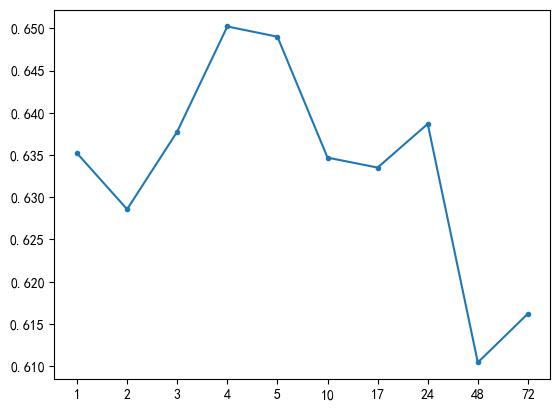

In [17]:
def to_chunks(values, chunk_ix=0):
    chunks = list()
    chunk_ids = np.unique(values[:, chunk_ix])
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks.append(values[selection, :])
    return chunks

def get_lead_times():
    return [1, 2 ,3, 4, 5, 10, 17, 24, 48, 72]

def forecast_variable(train_chunks, chunk_train, chunk_test, lead_times, target_ix):
    col_ix = 3 + target_ix
    all_obs = list()
    for chunk in train_chunks:
        all_obs += [x for x in chunk[:, col_ix]]
    value = np.nanmean(all_obs)
    return [value for _ in lead_times]

def forecast_chunks(train_chunks, test_input):
    lead_times = get_lead_times()
    predictions = list()
    for i in range(len(train_chunks)):
        chunk_predictions = list()
        for j in range(39):
            yhat = forecast_variable(train_chunks, train_chunks[i], test_input[i], lead_times, j)
            chunk_predictions.append(yhat)
        chunk_predictions = np.array(chunk_predictions)
        predictions.append(chunk_predictions)
    return np.array(predictions)

def prepare_test_forecasts(test_chunks):
    predictions = list()
    for rows in test_chunks:
        chunk_predictions = list()
        for j in range(3, rows.shape[1]):
            yhat = rows[:, j]
            chunk_predictions.append(yhat)
        chunk_predictions = np.array(chunk_predictions)
        predictions.append(chunk_predictions)
    return np.array(predictions)

def calculate_error(actual, predicted):
    if np.isnan(predicted):
        return abs(actual)
    return abs(actual - predicted)

def evaluate_forecasts(predictions, testset):
    lead_times = get_lead_times()
    total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
    total_c, times_c = 0, [0 for _ in range(len(lead_times))]
    for i in range(len(test_chunks)):
        actual = testset[i]
        predicted = predictions[i]
        for j in range(predicted.shape[0]):
            for k in range(len(lead_times)):
                if np.isnan(actual[j, k]):
                    continue
                error = calculate_error(actual[j, k], predicted[j, k])
                total_mae += error
                times_mae[k] += error
                total_c += 1
                times_c[k] += 1
    total_mae /= total_c
    times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
    return total_mae, times_mae

def summarize_error(name, total_mae, times_mae):
    lead_times = get_lead_times()
    formatted = ['+%d %.3f' % (lead_times[i], times_mae[i]) for i in range(len(lead_times))]
    s_scores = ', '.join(formatted)
    print('%s: [%.3f MAE] %s' % (name, total_mae, s_scores))
    plt.plot([str(x) for x in lead_times], times_mae, marker='.')
    plt.show()

train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
summarize_error('Global Median', total_mae, times_mae) # MAE 按预测提前期与全球平均值

##### 可以更新示例以预测全局中位数而不是平均值。对于这些数据，中位数可能比用作该数据的平均值更有意义，因为数据似乎显示的是非高斯分布。

Global Median: [0.598 MAE] +1 0.601, +2 0.594, +3 0.600, +4 0.611, +5 0.615, +10 0.594, +17 0.592, +24 0.602, +48 0.585, +72 0.580


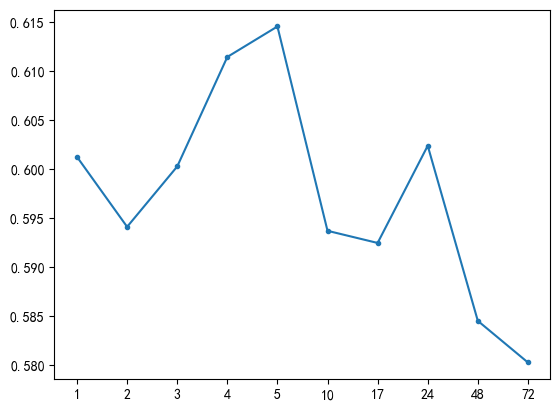

In [18]:
def forecast_variable(train_chunks, chunk_train, chunk_test, lead_times, target_ix):
    col_ix = 3 + target_ix
    all_obs = list()
    for chunk in train_chunks:
        all_obs += [x for x in chunk[:, col_ix]]
    value = np.nanmedian(all_obs)
    return [value for _ in lead_times]
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
summarize_error('Global Median', total_mae, times_mae) # MAE 按预测提前期与全球中位数

##### 运行该示例显示MAE下降至约0.59，这表明确实使用中位数作为中心趋势可能是一个更好的基线策略。
#### 用每一天中每小时的均值作为预测值

Global Median by hour: [0.567 MAE] +1 0.573, +2 0.565, +3 0.567, +4 0.579, +5 0.589, +10 0.559, +17 0.565, +24 0.567, +48 0.558, +72 0.551


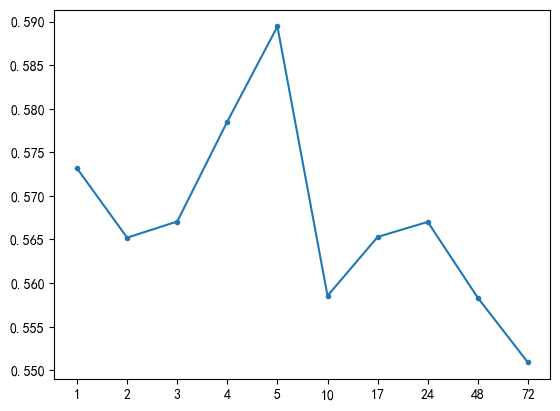

In [19]:
# forecast all lead times for one variable
def forecast_variable(train_chunks, chunk_train, chunk_test, lead_times, target_ix):
    forecast = list()
    col_ix = 3 + target_ix
    for i in range(len(lead_times)):
        hour = chunk_test[i, 2]
        if np.isnan(hour):
            forecast.append(np.nan)
            continue
        all_rows = list()
        for rows in train_chunks:
            [all_rows.append(row) for row in rows[rows[:,2]==hour]]
        all_rows = np.array(all_rows)
        value = np.nanmedian(all_rows[:, col_ix])
        forecast.append(value)
    return forecast
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
summarize_error('Global Median by hour', total_mae, times_mae) # MAE 按预测提前期与全球中位数按一天中的小时

##### 运行该示例汇总了模型的性能，MAE 为 0.567，这比每个序列的全局中位数有所改进。还创建了按预测提前期划分的 MAE 线图，显示 +72 的总体预测误差最低。这很有趣，并且可能表明基于小时的信息在更复杂的模型中可能很有用。
#### 用每个块的最后观察值作为预测值

Persistence: [0.520 MAE] +1 0.217, +2 0.330, +3 0.400, +4 0.471, +5 0.515, +10 0.648, +17 0.656, +24 0.589, +48 0.671, +72 0.708


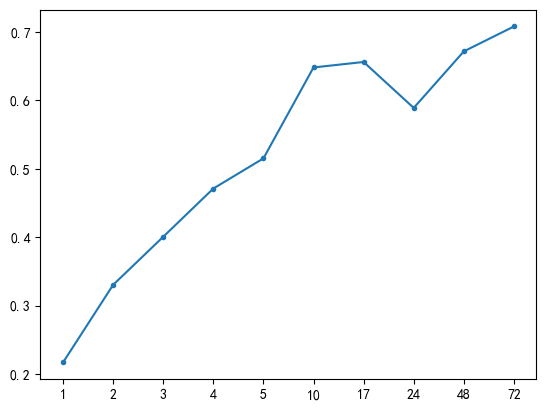

In [20]:
def forecast_variable(train_chunks, chunk_train, chunk_test, lead_times, target_ix):
    col_ix = 3 + target_ix
    history = chunk_train[:, col_ix]
    persisted = np.nan
    for value in reversed(history):
        if not np.isnan(value):
            persisted = value
            break
    forecast = [persisted for _ in range(len(lead_times))]
    return forecast
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
summarize_error('Persistence', total_mae, times_mae) # 通过持久性预测提前期的 MAE

##### 可以看到，持久性预测的表现似乎优于上一节中评估的所有全局策略。这增加了一些支持，即特定于块的信息在建模此问题时很重要的合理假设。
#### 用每个数据块整体的中值作为预测值

Local Median: [0.568 MAE] +1 0.535, +2 0.542, +3 0.550, +4 0.568, +5 0.568, +10 0.562, +17 0.567, +24 0.605, +48 0.590, +72 0.593


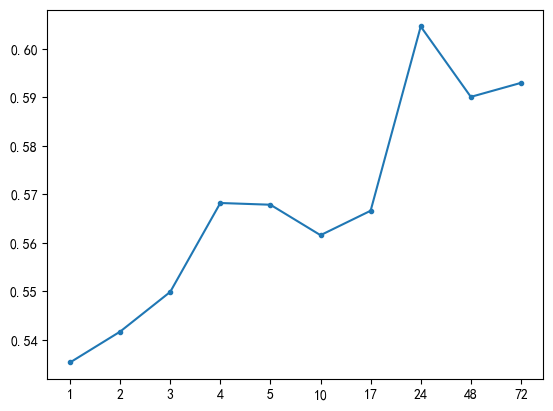

In [21]:
def forecast_variable(train_chunks, chunk_train, chunk_test, lead_times, target_ix):
    col_ix = 3 + target_ix
    history = chunk_train[:, col_ix]
    value = np.nanmedian(history)
    forecast = [value for _ in range(len(lead_times))]
    return forecast
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
summarize_error('Local Median', total_mae, times_mae) # MAE 通过本地中位数预测提前期

##### 运行示例总结了这种朴素策略的性能，显示 MAE 约为 0.568，比上述持久性策略差。还创建了每个预测提前期的 MAE 线图，显示了熟悉的每个提前期误差递增曲线。
#### 用每一天中每小时的中值作为预测值

Local Median by Hour: [0.574 MAE] +1 0.561, +2 0.559, +3 0.568, +4 0.577, +5 0.577, +10 0.556, +17 0.551, +24 0.588, +48 0.601, +72 0.608


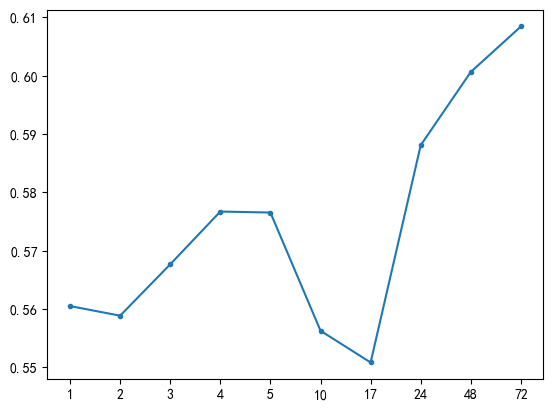

In [22]:
def forecast_variable(train_chunks, chunk_train, chunk_test, lead_times, target_ix):
    forecast = list()
    col_ix = 3 + target_ix
    for i in range(len(lead_times)):
        hour = chunk_test[i, 2]
        if np.isnan(hour):
            forecast.append(np.nan)
            continue
        selected = chunk_train[chunk_train[:,2]==hour]        
        value = np.nanmedian(selected[:, col_ix])
        forecast.append(value)
    return forecast
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
summarize_error('Local Median by Hour', total_mae, times_mae)

##### 运行该示例打印的整体 MAE 约为 0.574，这比同一策略的全局变化更差。正如所怀疑的那样，这可能是由于样本量小，即每个预测最多有五行训练数据。还创建了每个预测提前期的 MAE 线图，显示了熟悉的每个提前期误差递增曲线。
#### 结果摘要

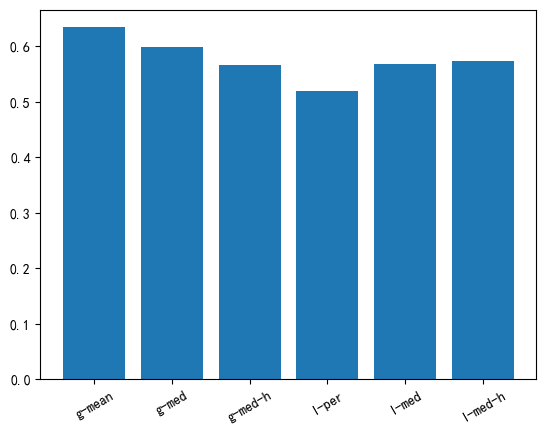

In [23]:
# summary of results
from matplotlib import pyplot
# results
results = {
    'g-mean':0.634,
    'g-med':0.598,
    'g-med-h':0.567,
    'l-per':0.520,
    'l-med':0.568,
    'l-med-h':0.574}
# plot
plt.bar(results.keys(), results.values())
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)
plt.show()

##### 运行该示例会创建一个条形图，比较六种策略中每种策略的 MAE。我们可以看到，持久性策略优于所有其他方法，其次好的策略是使用一天中小时的每个序列的全局中位数。在数据集的这种训练/测试分离上评估的模型必须达到低于 0.520 的总体 MAE 才能被认为是熟练的。

### Part 3 空气污染预测的自回归模型
#### 将数据拆分成训练集和测试集

In [24]:
def to_chunks(values, chunk_ix=1):
    chunks = dict()
    chunk_ids = np.unique(values[:, chunk_ix])
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks[chunk_id] = values[selection, :]
    return chunks

def split_train_test(chunks, row_in_chunk_ix=2):
    train, test = list(), list()
    cut_point = 5 * 24
    for k,rows in chunks.items():
        train_rows = rows[rows[:,row_in_chunk_ix] <= cut_point, :]
        test_rows = rows[rows[:,row_in_chunk_ix] > cut_point, :]
        if len(train_rows) == 0 or len(test_rows) == 0:
            print('>dropping chunk=%d: train=%s, test=%s' % (k, train_rows.shape, test_rows.shape))
            continue
        indices = [1,2,5] + [x for x in range(56,train_rows.shape[1])]
        train.append(train_rows[:, indices])
        test.append(test_rows[:, indices])
    return train, test

def get_lead_times():
    return [1, 2 ,3, 4, 5, 10, 17, 24, 48, 72]

def to_forecasts(test_chunks, row_in_chunk_ix=1):
    lead_times = get_lead_times()
    cut_point = 5 * 24
    forecasts = list()
    for rows in test_chunks:
        chunk_id = rows[0, 0]
        for tau in lead_times:
            offset = cut_point + tau
            row_for_tau = rows[rows[:,row_in_chunk_ix]==offset, :]
            if len(row_for_tau) == 0:
                row = [chunk_id, offset, np.nan] + [np.nan for _ in range(39)]
                forecasts.append(row)
            else:
                forecasts.append(row_for_tau[0])
    return np.array(forecasts)

dataset = pd.read_csv('TrainingData.csv', header=0)
values = dataset.values
chunks = to_chunks(values)
train, test = split_train_test(chunks)
train_rows = np.array([row for rows in train for row in rows])
print('Train Rows: %s' % str(train_rows.shape))
test_rows = to_forecasts(test)
print('Test Rows: %s' % str(test_rows.shape))
np.savetxt('./naive_train.csv', train_rows, delimiter=',')
np.savetxt('./naive_test.csv', test_rows, delimiter=',')

>dropping chunk=69: train=(0, 95), test=(28, 95)
Train Rows: (23514, 42)
Test Rows: (2070, 42)


##### 可以看到每个训练集和测试集中都有 42 列，一列用于块 id、块内的位置、一天中的小时和 39 个训练变量。还可以看到测试数据集的大幅缩小版本，其中行仅在预测提前期。新的训练数据集和测试数据集分别保存在“naive_train.csv”和“naive_test.csv”文件中。
#### 缺失数据展示

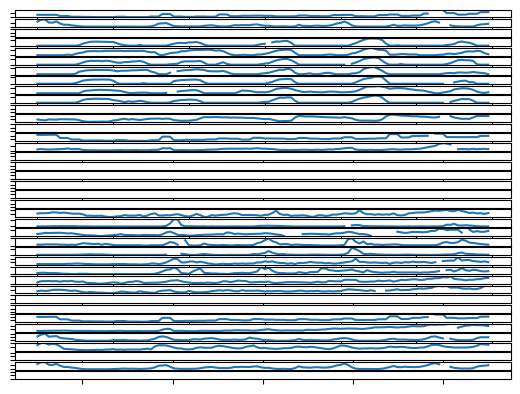

In [25]:
def to_chunks(values, chunk_ix=0):
    chunks = list()
    # get the unique chunk ids
    chunk_ids = np.unique(values[:, chunk_ix])
    # group rows by chunk id
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks.append(values[selection, :])
    return chunks

def variable_to_series(chunk_train, col_ix, n_steps=5*24):
    data = [np.nan for _ in range(n_steps)]
    for i in range(len(chunk_train)):
        position = int(chunk_train[i, 1] - 1)
        data[position] = chunk_train[i, col_ix]
    return data

def plot_variables(chunk_train, n_vars=39):
    plt.figure()
    for i in range(n_vars):
        col_ix = 3 + i
        series = variable_to_series(chunk_train, col_ix)
        # plot
        ax = plt.subplot(n_vars, 1, i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.plot(series)
    # show plot
    plt.show()
    
train = np.loadtxt('./naive_train.csv', delimiter=',')
train_chunks = to_chunks(train)
rows = train_chunks[0] # 区块 1 中所有目标的线图，其中标记了缺失值
plot_variables(rows)

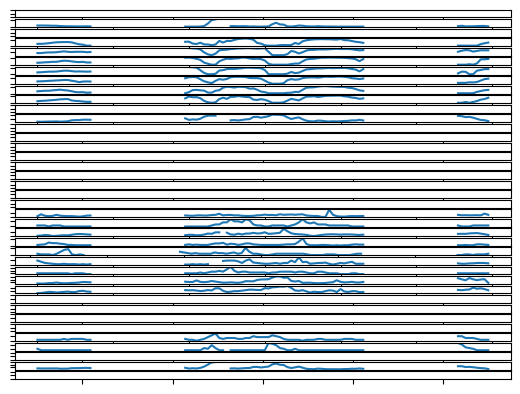

In [26]:
rows = train_chunks[3] # 区块 4 中所有目标的线图，其中标记了缺失值
plot_variables(rows)

#### 填补缺失数据

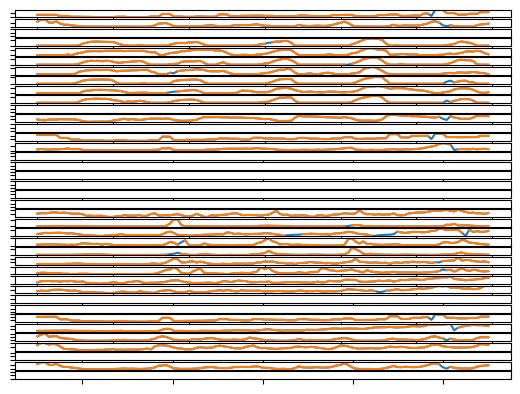

In [27]:
def to_chunks(values, chunk_ix=0):
    chunks = list()
    # get the unique chunk ids
    chunk_ids = np.unique(values[:, chunk_ix])
    # group rows by chunk id
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks.append(values[selection, :])
    return chunks

def impute_missing(rows, hours, series, col_ix):
    # count missing observations
    n_missing = np.count_nonzero(np.isnan(series))
    # calculate ratio of missing
    ratio = n_missing / float(len(series)) * 100
    # check for no data
    if ratio == 100.0:
        return series
    # impute missing using the median value for hour in the series
    imputed = list()
    for i in range(len(series)):
        if np.isnan(series[i]):
            # get all rows with the same hour
            matches = rows[rows[:,2]==hours[i]]
            # fill with median value
            value = np.nanmedian(matches[:, col_ix])
            imputed.append(value)
        else:
            imputed.append(series[i])
    return imputed

# interpolate series of hours (in place) in 24 hour time
def interpolate_hours(hours):
    # find the first hour
    ix = -1
    for i in range(len(hours)):
        if not np.isnan(hours[i]):
            ix = i
            break
    # fill-forward
    hour = hours[ix]
    for i in range(ix+1, len(hours)):
        # increment hour
        hour += 1
        # check for a fill
        if np.isnan(hours[i]):
            hours[i] = hour % 24
    # fill-backward
    hour = hours[ix]
    for i in range(ix-1, -1, -1):
        # decrement hour
        hour -= 1
        # check for a fill
        if np.isnan(hours[i]):
            hours[i] = hour % 24

# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
    # lay out whole series
    data = [np.nan for _ in range(n_steps)]
    # mark all available data
    for i in range(len(chunk_train)):
        # get position in chunk
        position = int(chunk_train[i, 1] - 1)
        # store data
        data[position] = chunk_train[i, col_ix]
    return data

# plot variables horizontally with gaps for missing data
def plot_variables(chunk_train, hours, n_vars=39):
    plt.figure()
    for i in range(n_vars):
        # convert target number into column number
        col_ix = 3 + i
        # mark missing obs for variable
        series = variable_to_series(chunk_train, col_ix)
        ax = plt.subplot(n_vars, 1, i+1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # imputed
        imputed = impute_missing(chunk_train, hours, series, col_ix)
        # plot imputed
        plt.plot(imputed)
        # plot with missing
        plt.plot(series)
    # show plot
    plt.show()

# load dataset
train = np.loadtxt('./naive_train.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
# pick one chunk
rows = train_chunks[0]
# prepare sequence of hours for the chunk
hours = variable_to_series(rows, 2)
# interpolate hours
interpolate_hours(hours)
# plot variables
plot_variables(rows, hours)

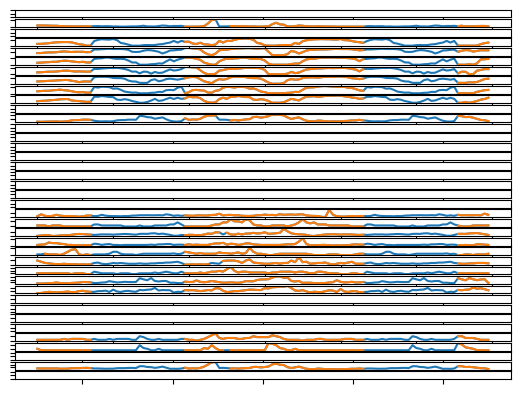

In [28]:
rows = train_chunks[3] # 区块 4 中所有目标的线图，带有插补缺失值
plot_variables(rows, hours)

##### 训练数据集中第一个区块中的每个目标变量对应一个线图。可以看到该序列是橙色的，显示原始数据，差距已补并标记为蓝色。
#### 观察39列每列数据的自相关和偏相关图

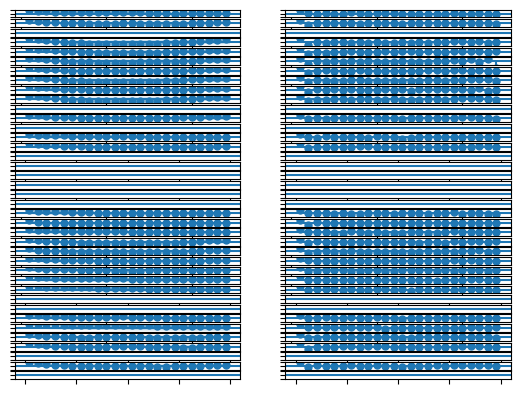

In [29]:
# acf and pacf plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
    chunks = list()
    # get the unique chunk ids
    chunk_ids = np.unique(values[:, chunk_ix])
    # group rows by chunk id
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks.append(values[selection, :])
    return chunks

# impute missing data
def impute_missing(rows, hours, series, col_ix):
    # count missing observations
    n_missing = np.count_nonzero(np.isnan(series))
    # calculate ratio of missing
    ratio = n_missing / float(len(series)) * 100
    # check for no data
    if ratio == 100.0:
        return series
    # impute missing using the median value for hour in the series
    imputed = list()
    for i in range(len(series)):
        if np.isnan(series[i]):
            # get all rows with the same hour
            matches = rows[rows[:,2]==hours[i]]
            # fill with median value
            value = np.nanmedian(matches[:, col_ix])
            imputed.append(value)
        else:
            imputed.append(series[i])
    return imputed

# interpolate series of hours (in place) in 24 hour time
def interpolate_hours(hours):
    # find the first hour
    ix = -1
    for i in range(len(hours)):
        if not np.isnan(hours[i]):
            ix = i
            break
    # fill-forward
    hour = hours[ix]
    for i in range(ix+1, len(hours)):
        # increment hour
        hour += 1
        # check for a fill
        if np.isnan(hours[i]):
            hours[i] = hour % 24
    # fill-backward
    hour = hours[ix]
    for i in range(ix-1, -1, -1):
        # decrement hour
        hour -= 1
        # check for a fill
        if np.isnan(hours[i]):
            hours[i] = hour % 24

# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
    # lay out whole series
    data = [np.nan for _ in range(n_steps)]
    # mark all available data
    for i in range(len(chunk_train)):
        # get position in chunk
        position = int(chunk_train[i, 1] - 1)
        # store data
        data[position] = chunk_train[i, col_ix]
    return data

# plot acf and pacf plots for each imputed variable series
def plot_variables(chunk_train, hours, n_vars=39):
    plt.figure()
    n_plots = n_vars * 2
    j = 0
    lags = 24
    for i in range(1, n_plots, 2):
        # convert target number into column number
        col_ix = 3 + j
        j += 1
        # get series
        series = variable_to_series(chunk_train, col_ix)
        imputed = impute_missing(chunk_train, hours, series, col_ix)
        # acf
        axis = plt.subplot(n_vars, 2, i)
        plot_acf(imputed, ax=axis, lags=lags, zero=False)
        axis.set_title('')
        axis.set_xticklabels([])
        axis.set_yticklabels([])
        # pacf
        axis = plt.subplot(n_vars, 2, i+1)
        plot_pacf(imputed, ax=axis, lags=lags, zero=False)
        axis.set_title('')
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    # show plot
    plt.show()

# load dataset
train = np.loadtxt('./naive_train.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
# pick one chunk
rows = train_chunks[0]
# prepare sequence of hours for the chunk
hours = variable_to_series(rows, 2)
# interpolate hours
interpolate_hours(hours)
# plot variables
plot_variables(rows, hours)

##### 可以在左侧看到，大多数 ACF 图在滞后 1-2 步处显示出显着的相关性（显著性区域上方的点），在某些情况下可能滞后 1-3 步，在滞后期间缓慢、稳定地下降同样，在右侧，我们可以看到 PACF 图在 1-2 个时间步长处出现显着滞后，并出现陡峭的衰减。这强烈表明存在一个自相关过程，其数量级可能为 1、2 或 3，例如 AR（3）。在左侧的ACF图中，我们还可以看到相关性的每日周期。这可能表明，在建模之前对数据进行季节性差异或使用能够进行季节性差异的AR模型有一些好处。
#### 自回归模型

AR: [0.492 MAE] +1 0.225, +2 0.341, +3 0.410, +4 0.475, +5 0.512, +10 0.593, +17 0.586, +24 0.588, +48 0.588, +72 0.604


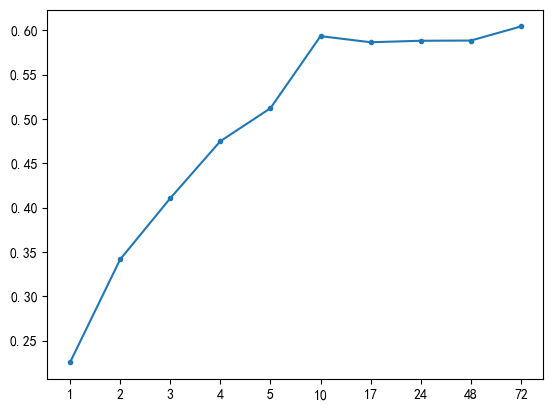

In [30]:
# autoregression forecast
from statsmodels.tsa.arima.model import ARIMA
from warnings import catch_warnings
from warnings import filterwarnings

# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
    chunks = list()
    # get the unique chunk ids
    chunk_ids = np.unique(values[:, chunk_ix])
    # group rows by chunk id
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks.append(values[selection, :])
    return chunks

# return a list of relative forecast lead times
def get_lead_times():
    return [1, 2, 3, 4, 5, 10, 17, 24, 48, 72]

# interpolate series of hours (in place) in 24 hour time
def interpolate_hours(hours):
    # find the first hour
    ix = -1
    for i in range(len(hours)):
        if not np.isnan(hours[i]):
            ix = i
            break
    # fill-forward
    hour = hours[ix]
    for i in range(ix+1, len(hours)):
        # increment hour
        hour += 1
        # check for a fill
        if np.isnan(hours[i]):
            hours[i] = hour % 24
    # fill-backward
    hour = hours[ix]
    for i in range(ix-1, -1, -1):
        # decrement hour
        hour -= 1
        # check for a fill
        if np.isnan(hours[i]):
            hours[i] = hour % 24

# return true if the array has any non-nan values
def has_data(data):
    return np.count_nonzero(np.isnan(data)) < len(data)

# impute missing data
def impute_missing(rows, hours, series, col_ix):
    # impute missing using the median value for hour in the series
    imputed = list()
    for i in range(len(series)):
        if np.isnan(series[i]):
            # get all rows with the same hour
            matches = rows[rows[:,2]==hours[i]]
            # fill with median value
            value = np.nanmedian(matches[:, col_ix])
            if np.isnan(value):
                value = 0.0
            imputed.append(value)
        else:
            imputed.append(series[i])
    return imputed

# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
    # lay out whole series
    data = [np.nan for _ in range(n_steps)]
    # mark all available data
    for i in range(len(chunk_train)):
        # get position in chunk
        position = int(chunk_train[i, 1] - 1)
        # store data
        data[position] = chunk_train[i, col_ix]
    return data

# fit AR model and generate a forecast
def fit_and_forecast(series):
    # define the model
    model = ARIMA(series, order=(1,0,0))
    # return a nan forecast in case of exception
    try:
        # ignore statsmodels warnings
        with catch_warnings():
            filterwarnings("ignore")
            # fit the model
            model_fit = model.fit()
            # forecast 72 hours
            yhat = model_fit.predict(len(series), len(series)+72)
            # extract lead times
            lead_times = np.array(get_lead_times())
            indices = lead_times - 1
            return yhat[indices]
    except:
        return [np.nan for _ in range(len(get_lead_times()))]

# forecast all lead times for one variable
def forecast_variable(hours, chunk_train, chunk_test, lead_times, target_ix):
    # convert target number into column number
    col_ix = 3 + target_ix
    # check for no data
    if not has_data(chunk_train[:, col_ix]):
        forecast = [np.nan for _ in range(len(lead_times))]
        return forecast
    # get series
    series = variable_to_series(chunk_train, col_ix)
    # impute
    imputed = impute_missing(chunk_train, hours, series, col_ix)
    # fit AR model and forecast
    forecast = fit_and_forecast(imputed)
    return forecast

# forecast for each chunk, returns [chunk][variable][time]
def forecast_chunks(train_chunks, test_input):
    lead_times = get_lead_times()
    predictions = list()
    # enumerate chunks to forecast
    for i in range(len(train_chunks)):
        # prepare sequence of hours for the chunk
        hours = variable_to_series(train_chunks[i], 2)
        # interpolate hours
        interpolate_hours(hours)
        # enumerate targets for chunk
        chunk_predictions = list()
        for j in range(39):
            yhat = forecast_variable(hours, train_chunks[i], test_input[i], lead_times, j)
            chunk_predictions.append(yhat)
        chunk_predictions = np.array(chunk_predictions)
        predictions.append(chunk_predictions)
    return np.array(predictions)

# convert the test dataset in chunks to [chunk][variable][time] format
def prepare_test_forecasts(test_chunks):
    predictions = list()
    # enumerate chunks to forecast
    for rows in test_chunks:
        # enumerate targets for chunk
        chunk_predictions = list()
        for j in range(3, rows.shape[1]):
            yhat = rows[:, j]
            chunk_predictions.append(yhat)
        chunk_predictions = np.array(chunk_predictions)
        predictions.append(chunk_predictions)
    return np.array(predictions)

# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
    # give the full actual value if predicted is nan
    if np.isnan(predicted):
        return abs(actual)
    # calculate abs difference
    return abs(actual - predicted)

# evaluate a forecast in the format [chunk][variable][time]
def evaluate_forecasts(predictions, testset):
    lead_times = get_lead_times()
    total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
    total_c, times_c = 0, [0 for _ in range(len(lead_times))]
    # enumerate test chunks
    for i in range(len(test_chunks)):
        # convert to forecasts
        actual = testset[i]
        predicted = predictions[i]
        # enumerate target variables
        for j in range(predicted.shape[0]):
            # enumerate lead times
            for k in range(len(lead_times)):
                # skip if actual in nan
                if np.isnan(actual[j, k]):
                    continue
                # calculate error
                error = calculate_error(actual[j, k], predicted[j, k])
                # update statistics
                total_mae += error
                times_mae[k] += error
                total_c += 1
                times_c[k] += 1
    # normalize summed absolute errors
    total_mae /= total_c
    times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
    return total_mae, times_mae

# summarize scores
def summarize_error(name, total_mae, times_mae):
    # print summary
    lead_times = get_lead_times()
    formatted = ['+%d %.3f' % (lead_times[i], times_mae[i]) for i in range(len(lead_times))]
    s_scores = ', '.join(formatted)
    print('%s: [%.3f MAE] %s' % (name, total_mae, s_scores))
    # plot summary
    plt.plot([str(x) for x in lead_times], times_mae, marker='.')
    plt.show()

# load dataset
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
# forecast
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
# evaluate forecast
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
# summarize forecast
summarize_error('AR', total_mae, times_mae)

AR: [0.489 MAE] +1 0.226, +2 0.339, +3 0.410, +4 0.471, +5 0.502, +10 0.563, +17 0.576, +24 0.604, +48 0.597, +72 0.608


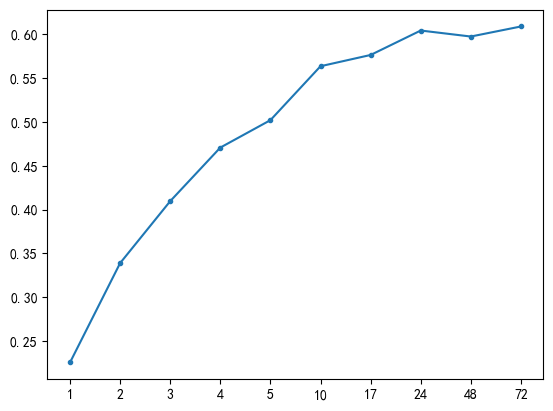

In [31]:
def fit_and_forecast(series):
    # define the model
    model = ARIMA(series, order=(2,0,0)) # AR（2） 模型
    # return a nan forecast in case of exception
    try:
        # ignore statsmodels warnings
        with catch_warnings():
            filterwarnings("ignore")
            # fit the model
            model_fit = model.fit()
            # forecast 72 hours
            yhat = model_fit.predict(len(series), len(series)+72)
            # extract lead times
            lead_times = np.array(get_lead_times())
            indices = lead_times - 1
            return yhat[indices]
    except:
        return [np.nan for _ in range(len(get_lead_times()))]
# load dataset
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
# forecast
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
# evaluate forecast
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
# summarize forecast
summarize_error('AR', total_mae, times_mae)

AR: [0.489 MAE] +1 0.228, +2 0.342, +3 0.410, +4 0.472, +5 0.502, +10 0.556, +17 0.574, +24 0.604, +48 0.597, +72 0.609


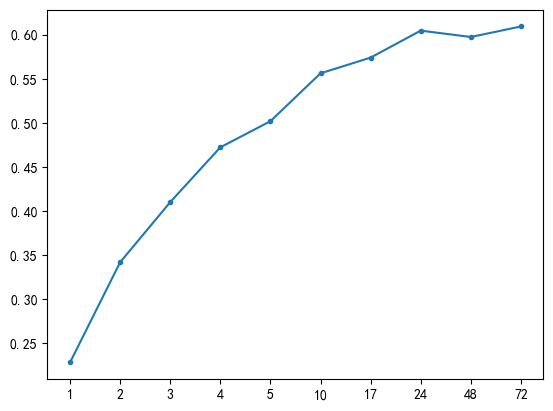

In [32]:
def fit_and_forecast(series):
    # define the model
    model = ARIMA(series, order=(3,0,0)) # AR（3） 模型
    # return a nan forecast in case of exception
    try:
        # ignore statsmodels warnings
        with catch_warnings():
            filterwarnings("ignore")
            # fit the model
            model_fit = model.fit()
            # forecast 72 hours
            yhat = model_fit.predict(len(series), len(series)+72)
            # extract lead times
            lead_times = np.array(get_lead_times())
            indices = lead_times - 1
            return yhat[indices]
    except:
        return [np.nan for _ in range(len(get_lead_times()))]
# load dataset
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
# forecast
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
# evaluate forecast
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
# summarize forecast
summarize_error('AR', total_mae, times_mae)

##### 运行示例首先报告测试集的总体 MAE，然后报告每个预测提前期的 MAE。可以看到，AR(1)模型实现了大约 0.492 的 MAE，AR(2)模型实现了大约 0.489 的 MAE,AR(3)模型实现了大约 0.489 的 MAE,都小于朴素持久性模型实现的 MAE 0.520。这表明这种方法确实有一定的技巧。
#### 具有全局插补策略的自回归模型

AR: [0.486 MAE] +1 0.225, +2 0.336, +3 0.406, +4 0.467, +5 0.498, +10 0.560, +17 0.573, +24 0.599, +48 0.594, +72 0.606


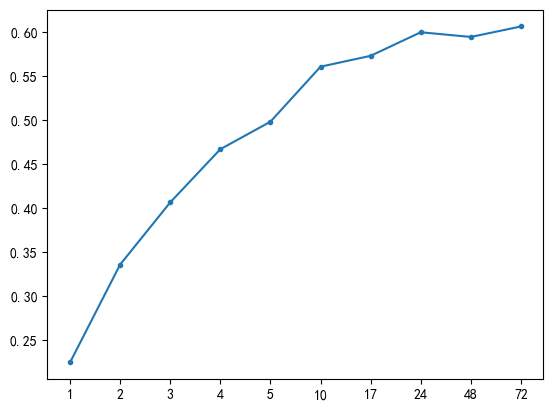

In [33]:
# split the dataset by 'chunkID', return a list of chunks
def to_chunks(values, chunk_ix=0):
    chunks = list()
    # get the unique chunk ids
    chunk_ids = np.unique(values[:, chunk_ix])
    # group rows by chunk id
    for chunk_id in chunk_ids:
        selection = values[:, chunk_ix] == chunk_id
        chunks.append(values[selection, :])
    return chunks

# return a list of relative forecast lead times
def get_lead_times():
    return [1, 2, 3, 4, 5, 10, 17, 24, 48, 72]

# interpolate series of hours (in place) in 24 hour time
def interpolate_hours(hours):
    # find the first hour
    ix = -1
    for i in range(len(hours)):
        if not np.isnan(hours[i]):
            ix = i
            break
    # fill-forward
    hour = hours[ix]
    for i in range(ix+1, len(hours)):
        # increment hour
        hour += 1
        # check for a fill
        if np.isnan(hours[i]):
            hours[i] = hour % 24
    # fill-backward
    hour = hours[ix]
    for i in range(ix-1, -1, -1):
        # decrement hour
        hour -= 1
        # check for a fill
        if np.isnan(hours[i]):
            hours[i] = hour % 24

# return true if the array has any non-nan values
def has_data(data):
    return np.count_nonzero(np.isnan(data)) < len(data)

# impute missing data
def impute_missing(train_chunks, rows, hours, series, col_ix):
    # impute missing using the median value for hour in all series
    imputed = list()
    for i in range(len(series)):
        if np.isnan(series[i]):
            # collect all rows across all chunks for the hour
            all_rows = list()
            for rows in train_chunks:
                [all_rows.append(row) for row in rows[rows[:,2]==hours[i]]]
            # calculate the central tendency for target
            all_rows = np.array(all_rows)
            # fill with median value
            value = np.nanmedian(all_rows[:, col_ix])
            if np.isnan(value):
                value = 0.0
            imputed.append(value)
        else:
            imputed.append(series[i])
    return imputed

# layout a variable with breaks in the data for missing positions
def variable_to_series(chunk_train, col_ix, n_steps=5*24):
    # lay out whole series
    data = [np.nan for _ in range(n_steps)]
    # mark all available data
    for i in range(len(chunk_train)):
        # get position in chunk
        position = int(chunk_train[i, 1] - 1)
        # store data
        data[position] = chunk_train[i, col_ix]
    return data

# fit AR model and generate a forecast
def fit_and_forecast(series):
    # define the model
    model = ARIMA(series, order=(2,0,0))
    # return a nan forecast in case of exception
    try:
        # ignore statsmodels warnings
        with catch_warnings():
            filterwarnings("ignore")
            # fit the model
            model_fit = model.fit()
            # forecast 72 hours
            yhat = model_fit.predict(len(series), len(series)+72)
            # extract lead times
            lead_times = np.array(get_lead_times())
            indices = lead_times - 1
            return yhat[indices]
    except:
        return [np.nan for _ in range(len(get_lead_times()))]

# forecast all lead times for one variable
def forecast_variable(hours, train_chunks, chunk_train, chunk_test, lead_times, target_ix):
    # convert target number into column number
    col_ix = 3 + target_ix
    # check for no data
    if not has_data(chunk_train[:, col_ix]):
        forecast = [np.nan for _ in range(len(lead_times))]
        return forecast
    # get series
    series = variable_to_series(chunk_train, col_ix)
    # impute
    imputed = impute_missing(train_chunks, chunk_train, hours, series, col_ix)
    # fit AR model and forecast
    forecast = fit_and_forecast(imputed)
    return forecast

# forecast for each chunk, returns [chunk][variable][time]
def forecast_chunks(train_chunks, test_input):
    lead_times = get_lead_times()
    predictions = list()
    # enumerate chunks to forecast
    for i in range(len(train_chunks)):
        # prepare sequence of hours for the chunk
        hours = variable_to_series(train_chunks[i], 2)
        # interpolate hours
        interpolate_hours(hours)
        # enumerate targets for chunk
        chunk_predictions = list()
        for j in range(39):
            yhat = forecast_variable(hours, train_chunks, train_chunks[i], test_input[i], lead_times, j)
            chunk_predictions.append(yhat)
        chunk_predictions = np.array(chunk_predictions)
        predictions.append(chunk_predictions)
    return np.array(predictions)

# convert the test dataset in chunks to [chunk][variable][time] format
def prepare_test_forecasts(test_chunks):
    predictions = list()
    # enumerate chunks to forecast
    for rows in test_chunks:
        # enumerate targets for chunk
        chunk_predictions = list()
        for j in range(3, rows.shape[1]):
            yhat = rows[:, j]
            chunk_predictions.append(yhat)
        chunk_predictions = np.array(chunk_predictions)
        predictions.append(chunk_predictions)
    return np.array(predictions)

# calculate the error between an actual and predicted value
def calculate_error(actual, predicted):
    # give the full actual value if predicted is nan
    if np.isnan(predicted):
        return abs(actual)
    # calculate abs difference
    return abs(actual - predicted)

# evaluate a forecast in the format [chunk][variable][time]
def evaluate_forecasts(predictions, testset):
    lead_times = get_lead_times()
    total_mae, times_mae = 0.0, [0.0 for _ in range(len(lead_times))]
    total_c, times_c = 0, [0 for _ in range(len(lead_times))]
    # enumerate test chunks
    for i in range(len(test_chunks)):
        # convert to forecasts
        actual = testset[i]
        predicted = predictions[i]
        # enumerate target variables
        for j in range(predicted.shape[0]):
            # enumerate lead times
            for k in range(len(lead_times)):
                # skip if actual in nan
                if np.isnan(actual[j, k]):
                    continue
                # calculate error
                error = calculate_error(actual[j, k], predicted[j, k])
                # update statistics
                total_mae += error
                times_mae[k] += error
                total_c += 1
                times_c[k] += 1
    # normalize summed absolute errors
    total_mae /= total_c
    times_mae = [times_mae[i]/times_c[i] for i in range(len(times_mae))]
    return total_mae, times_mae

# summarize scores
def summarize_error(name, total_mae, times_mae):
    # print summary
    lead_times = get_lead_times()
    formatted = ['+%d %.3f' % (lead_times[i], times_mae[i]) for i in range(len(lead_times))]
    s_scores = ', '.join(formatted)
    print('%s: [%.3f MAE] %s' % (name, total_mae, s_scores))
    # plot summary
    plt.plot([str(x) for x in lead_times], times_mae, marker='.')
    plt.show()

# load dataset
train = np.loadtxt('./naive_train.csv', delimiter=',')
test = np.loadtxt('./naive_test.csv', delimiter=',')
# group data by chunks
train_chunks = to_chunks(train)
test_chunks = to_chunks(test)
# forecast
test_input = [rows[:, :3] for rows in test_chunks]
forecast = forecast_chunks(train_chunks, test_input)
# evaluate forecast
actual = prepare_test_forecasts(test_chunks)
total_mae, times_mae = evaluate_forecasts(forecast, actual)
# summarize forecast
summarize_error('AR', total_mae, times_mae)

##### 运行该示例显示整体 MAE 进一步下降至 0.486 左右。